# Exploring Model Extensibility for Named Entity Recognition: A Case Study on Catastrophic Incidents

## Table of Contents

[Introduction](#Introduction)\
[Imports](#Imports)\
[Prompt Engineering](#Prompt-Engineering)\
[Esri Model Definition(EMD) file](#Esri-Model-Definition(EMD)-file)\
[Anatomy of the Extension Function](#anatomy-of-the-extension-function)
* [Define the ```__init__``` function](#define-the-__init__-function)
* [Define the ```getParameterInfo``` function](#define-the-getconfiguration-function)
* [Define the ```initialize``` function](#define-the-initialize-function)
* [Define the ```getConfiguration``` function](#define-the-getparameterinfo-function)
* [Define the ```predict``` function](#define-the-predict-function)

[Complete NLP Function](#Complete-NLP-Function)\
[Create Custom ESRI Deep Learning Package (.dlpk) file](#Custom-Deep-Learning-Package-Model-File)\
[ESRI Deep Learning Package (.dlpk) file in arcgis.learn API](#Using-the-Custom-.dlpk-with-the-arcgis.learn-API)\
[Tool Interface](#tool-interface)\
[Sample Input Table](#Sample-Input-Table)\
[Sample Output Table](#Sample-Output-Table)\
[Conclusion](#conclusion)

---

## Introduction

The **GeoAI toolbox** features a comprehensive **Text Analysis toolset** designed for diverse text processing tasks, including _text classification, entity extraction, and text transformation_. Leveraging advanced natural language processing (NLP) models built on powerful backbones like BERT, RoBERTa, T5, and large language models (LLMs) such as Mistral, these tools deliver high-performance text analysis.

But what if you encounter a **Text model**, like a **BERT** or **T5** backbone-based language model, or a **large language model (LLM)** such as **LLaMA**, **Claude**, or **Mistral**, that isn’t included in the current learning module? Perhaps you want to utilize it from a library or an open-source code repository. Or maybe you’ve fine-tuned your own **text model** for specific tasks, such as standardizing addresses, conducting sentiment analysis, or extracting custom entities or relationships not currently supported by the Text Analysis toolset. How can you implement this within **ArcGIS Pro**?

To address these needs, ArcGIS allows for the integration of external third-party language models, including both open-source LLMs and commercial LLMs accessed via web APIs. Please note that if you use a web-hosted LLM, the data processed will be sent to the LLM provider. Python developers can create custom NLP functions to interface with these external models, packaging their models as ESRI Deep Learning Package (.dlpk) file for use with the following tools:

1. [Classify Text Using Deep Learning (GeoAI)](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/classify-text-using-deep-learning.htm)
2. [Extract Entities Using Deep Learning (GeoAI)](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/extract-entities-using-deep-learning.htm)
3. [Transform Text Using Deep Learning (GeoAI)](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/transform-text-using-deep-learning.htm)

The **ESRI Deep Learning Package (.dlpk)** file of the custom NLP function is also supported through the `arcgis.learn` Python API, which accommodates third-party custom models via various classes, including `TextClassifier`, `EntityRecognizer`, and `SequenceToSequence`.


**Named Entity Recognition (NER)** is a vital element of text analysis, designed to automatically identify and categorize entities within text, including people, locations, organizations, dates, and more, depending on the context. By extracting these entities, NER transforms unstructured data into a structured format, facilitating efficient analysis of large datasets. This is particularly beneficial in domain-specific scenarios, such as climate-related disasters, where NER can pinpoint crucial attributes like the type of event, affected locations, extent of damage, and impacted populations. Such capabilities enhance data organization, accelerate insights, and improve decision-making for analysis, reporting, and forecasting.

This work aims to showcase the functionality of the **Model Extension** for extracting named entities using a pre-trained model in a zero-shot setting. We will investigate a use case in which a summary of a catastrophic event is provided, focusing on the extraction of key entities such as the affected location, extent of damage, type of event, and date.

#### Intended Audience
- Analysts
- Extension model developers

#### Dataset
- [Billion-dollar disaster events](https://www.ncei.noaa.gov/access/billions/state-summary/US)

#### Capability Demonstration
- Out-of-the-box use of pre-trained model
- Minimal or no annotation required
- Comparable accuracy
- Integration of custom models within the ArcGIS Pro **Extract Entities Using Deep Learning (GeoAI)** and API


## Imports

In [ ]:
import os
import sys
import json
from arcgis.features import FeatureSet

## ESRI Model Definition (.emd) file

The ESRI Model Definition (.emd) file will contain both required and optional keys to ensure model execution. To run a extract entity model, we must provide the following essential keys:

1. **InferenceFunction**: This key specifies the name of the module that defines the NLP function.
2. **ModelType**: This key indicates the type of task. For the **Extract Entities Using Deep Learning (GeoAI)** tool, the value will be `Transformer`.
3. **ArcGISLearnVersion**: NLP functions are supported in `arcgis.learn` from version 2.4.0 onward. This parameter is used to exclude older `.dlpk` files that have unsupported NLP functions.

Additional keys can be defined at the discretion of the model extension author. In this instance, we have included the pre-trained model name under the key **PretrainedModel**.

In [ ]:

{
    "InferenceFunction": "MyCustomNER.py",
    "PretrainedModel": "urchade/gliner_large-v2.1",
    "ModelType": "Transformer",
    "ModelName": "_TransformerEntityRecognizer",
    "ArcGISLearnVersion": "2.4.0"
}

## Anatomy of the Extension Function 

The model extension requires the process be wrapped in a class that implements the following functions:

- `__init__`

- `getParameterInfo`

- `initialize`

- `getConfiguration`

- `predict`

Let's create a custom extension model to extract the following information:

- Impacted location
- Event date
- Quantity
- Property damage
- Climatic catastrophic event

To achieve this, we'll utilize the pre-trained Named Entity Recognition (NER) model from [GLiNER](https://github.com/urchade/GLiNER). We'll input the relevant text along with the specified entities we wish to extract. For our purposes, we'll focus on the entities listed above.

### Define the ```__init__``` function 

The `__init__` method initializes instance variables such as `name`, `description`, and other attributes essential for the NLP function.

In [ ]:
def __init__(self, **kwargs):
    self.name = "My Custom entity extractor"
    self.description = "Pre-trained model based extension function"

### Define the ```getParameterInfo``` function 

This function is designed to collect parameters from the user through Extract Entities Using Deep Learning (GeoAI). For our use case, it will gather the name of the **entity** to be extracted from the input text. The default value will be a comma-separated string of the aforementioned classes.

In [ ]:
def getParameterInfo(self):
    t =  [{
        "name": "classes",
        "dataType": "string",
        "required": False,
        "displayName": "name to classes",
        "description": "A comma separated string of class names",
        "value": 'impacted location,event date,quantity,property damage,climatic catastropic event'

    }]
    return t


### Define ```initialize``` function

The `initialize` function acts as the central hub for the extension. Within this function, we will set up the necessary variables. It accepts two parameters via `kwargs`:

#### Parameters in `kwargs`
- **`model`**: The path to the ESRI Model Definition (.emd) file.
- **`device`**: The name of the device (either GPU or CPU), which is particularly important for on-premises models.

Unlike the `__init__` method, which creates an instance of the NLP function, `initialize` reads the ESRI Model Definition (.emd) file and configures the essential variables needed for inference.

[GLiNER](https://github.com/urchade/GLiNER) is a Named Entity Recognition (NER) model that can identify any entity type using a bidirectional transformer encoder (similar to BERT). For deep learning functionality in ArcGIS Pro, supported deep learning framework libraries must be installed. The [Deep-learning-essentials](https://github.com/esri/deep-learning-frameworks) package provides a collection of essential packages for working with deep learning models and ArcGIS Pro. However, GLiNER is not included in Deep-learning-essentials, so we’ll use its repository to import the necessary classes and load the pre-trained model. Additionally, we will add placeholders for the specific classes to be extracted. 

In [ ]:
def initialize(self, **kwargs):
    with open(kwargs["model"]) as f:
        emd = json.load(f)
    model_name = emd["PretrainedModel"]
    sys.path.append(os.path.dirname(__file__))
    from GLiNER.gliner import GLiNER
    self.model = GLiNER.from_pretrained(model_name)
    self.considerd_class = kwargs.get("classes", considered_classes)

### Define the ```getConfiguration``` function 

This function receives `kwargs`, which contain parameter names and values collected from the user. Additionally, it will also contain parameters such as `batch_size`, which will control the tool's behavior. The **Extract Entities Using Deep Learning (GeoAI)** tool supports customization of `batch_size` and `address_tag`. The `batch_size` parameter determines how many records will be sent to the tool in a single batch, while `address_tag` specifies which entities will be geocoded.


In [ ]:
def getConfiguration(self, **kwargs):
    # Edit the batch size. Parameters to control the behaviour of the tool and post-process by the tool
    if kwargs["batch_size"] > 4:
        kwargs["batch_size"] = 4
    self.max_token = kwargs.get("max_token", 1024)
    try:
        self.max_token = float(self.max_token)
        if self.max_token > 1024:
            self.max_token = 512
    except:
        self.max_token = 512
    kwargs["address_tag"] = "impacted location"
    self.considerd_class = kwargs.get("classes", "").split(",")
    return kwargs

### Define the ```predict``` function 

This function serves as the entry point for performing inference on the input. It takes a `FeatureSet` as input along with the field name that contains the relevant data. First, we will retrieve the field name from the provided `kwargs` and use it to extract the list of sentences for inference.

In the next step, we will extract the input text for inference. The predicted output will be mapped to the corresponding class. Then, we will create a `FeatureSet` from the model's output. 

In [ ]:
def predict(self, feature_set, **kwargs):
    input_field = kwargs.get("input_field", "input_str")
    text_list = feature_set.df[input_field].to_list()
    # text_list = feature_set

    self.model = self.model.to('cuda')
    all_data = []
    features_list = []
    for text in text_list:
        temp_dict = {}
        for i in self.considerd_class:
            temp_dict[i] = [] 

        # Perform entity prediction
        entities = self.model.predict_entities(text, self.considerd_class, threshold=0.5)

        # Display predicted entities and their labels
        for entity in entities:
            # print(entity)
            temp_dict[entity["label"]] += [entity["text"]]
        for k,v in temp_dict.items():
            temp_dict[k] = ','.join(v)
        all_data.append(temp_dict)
        temp_dict["input_str"] = text
        features_list.append({'attributes':temp_dict})  

    field_class = []
    for i in self.considerd_class:
        field_class.append({"name": i, "type": "esriFieldTypeString"})
    field_class.append({"name": "input_str", "type": "esriFieldTypeString"})
    feature_dict = {
        "fields": field_class,
        'geometryType': "",
        'features':features_list
    }
    return FeatureSet.from_dict(feature_dict)

Finally, the tool will receive a `FeatureSet` as output from the extensible function.

## Complete NLP Function

In [ ]:
import os
import sys
import json
from arcgis.features import FeatureSet

 
considered_classes =["impacted location", "event date", "Quantity", "property damage", "climatic catastropic event"]
class MyCustomNER:
    def __init__(self, **kwargs):
        self.name = "My Custom entity extractor"
        self.description = "Pre-trained model based extension function"

    def initialize(self, **kwargs):
        with open(kwargs["model"]) as f:
            emd = json.load(f)
        model_name = emd["PretrainedModel"]
        sys.path.append(os.path.dirname(__file__))
        from GLiNER.gliner import GLiNER
        self.model = GLiNER.from_pretrained(model_name)
        self.considerd_class = kwargs.get("classes", considered_classes)

    
    def getConfiguration(self, **kwargs):
        # Edit the batch size. Parameters to control the behaviour of the tool and post-process by the tool
        if kwargs["batch_size"] > 4:
            kwargs["batch_size"] = 4
        self.max_token = kwargs.get("max_token", 1024)
        try:
            self.max_token = float(self.max_token)
            if self.max_token > 1024:
                self.max_token = 512
        except:
            self.max_token = 512
        kwargs["address_tag"] = "impacted location"
        self.considerd_class = kwargs.get("classes", "").split(",")
        return kwargs
    
    def getParameterInfo(self):
        t =  [{
            "name": "classes",
            "dataType": "integer",
            "required": False,
            "displayName": "name to classes",
            "description": "A comma separated string of class names",
            "value": 'impacted location,event date,Quantity,property damage,climatic catastropic event'

        }]
        return t
    
    def predict(self, feature_set, **kwargs):
        input_field = kwargs.get("input_field", "input_str")
        text_list = feature_set.df[input_field].to_list()
        # text_list = feature_set

        self.model = self.model.to('cuda')
        all_data = []
        features_list = []
        for text in text_list:
            temp_dict = {}
            for i in self.considerd_class:
                temp_dict[i] = [] 

            # Perform entity prediction
            entities = self.model.predict_entities(text, self.considerd_class, threshold=0.5)

            # Display predicted entities and their labels
            for entity in entities:
                # print(entity)
                temp_dict[entity["label"]] += [entity["text"]]
            for k,v in temp_dict.items():
                temp_dict[k] = ','.join(v)
            all_data.append(temp_dict)
            temp_dict["input_str"] = text
            features_list.append({'attributes':temp_dict})  

        field_class = []
        for i in self.considerd_class:
            field_class.append({"name": i, "type": "esriFieldTypeString"})
        field_class.append({"name": "input_str", "type": "esriFieldTypeString"})
        feature_dict = {
            "fields": field_class,
            'geometryType': "",
            'features':features_list
        }
        return FeatureSet.from_dict(feature_dict)

#### Key Points:
- All of the aforementioned functions must be encapsulated within a class.
- The class name should match the Inference Function file name, excluding the file extension.
- The author can define helper functions either within the class or in the module.
- The author is responsible for handling exceptions.
- The input field name must correspond to the name of the input field selected from the input table or feature layer.

## Custom Deep Learning Package Model File

To complete a custom NLP function setup, create a .dlpk model file. 

Organize the files as follows:

**Create a Folder**: Create a folder and include the custom NLP function file. In our case, we will create a folder `NER_gilner_weather`. Inside this, we will place `NER_gilner_weather.emd`, the NLP function file `MyCustomNER.py`, and the directory containing the code of `GLiNER`.


  ```      
NER_gilner_weather
├── MyCustomNER.py
├── GLiNER
└── NER_gilner_weather.emd

```

**Zip the Folder**: Create a ZIP archive of the folder. Rename the .zip file to match the name of the ESRI Model Definition (.emd) file but with the .dlpk extension. The ESRI Deep Learning Package (.dlpk) file's name will be `NER_gilner_weather.dlpk`

This .dlpk file is now ready for use with the arcgis.learn Python API and Extract Entities Using Deep Learning (GeoAI).

## Using the Custom ESRI Deep Learning Package (.dlpk) file with the arcgis.learn API

In [ ]:
from arcgis.learn.text import EntityRecognizer

# Initialize the model with the dlpk
model = EntityRecognizer.from_model(r"Path_to_the_dlpk\NER_gilner_weather.dlpk",
                                     classes =["impacted location", "event date", "Quantity", "property damage", "climatic catastropic event"])

# perform the inference
model.predict(["""Category 1 Hurricane Beryl made landfall in Texas on July 8 producing widespread high wind damage,
as the storm was restrengthening at landfall. One significant impact were power outages that impacted millions of people for days.
Beryl also produced more than 50 tornadoes across eastern Texas, western Louisiana and southern Arkansas.
On July 1, Beryl became the earliest Category 5 hurricane and the second Category 5 on record during the month of July in the Atlantic Ocean."""])

## Tool Interface

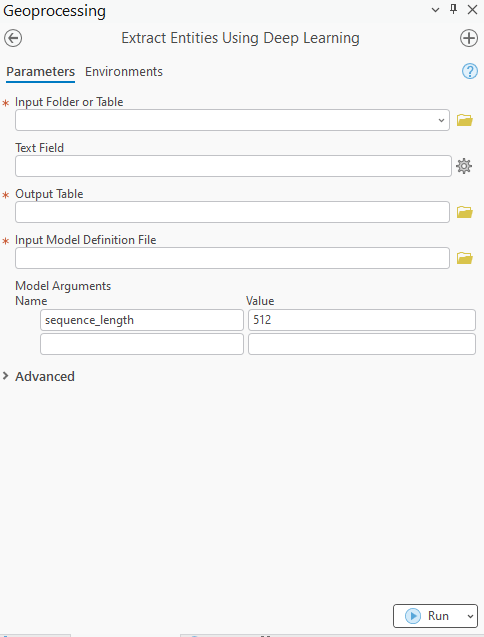

## Sample Input Table

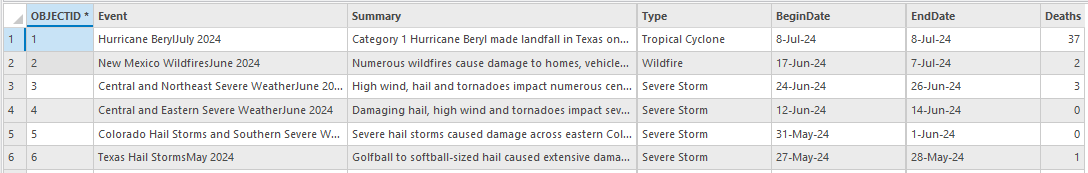

### After Extension File loading

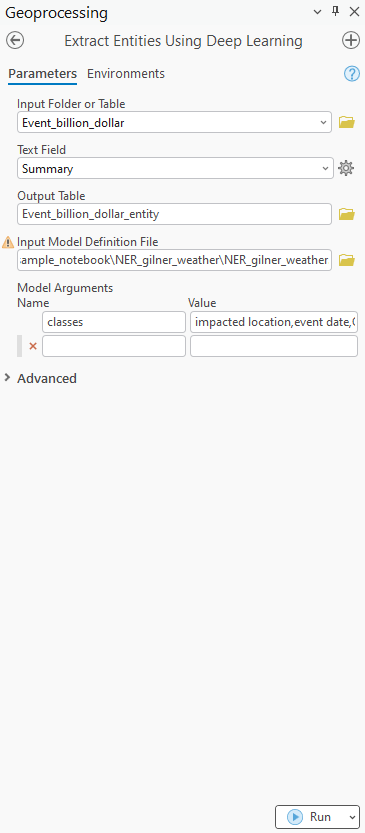

## Sample Output Table

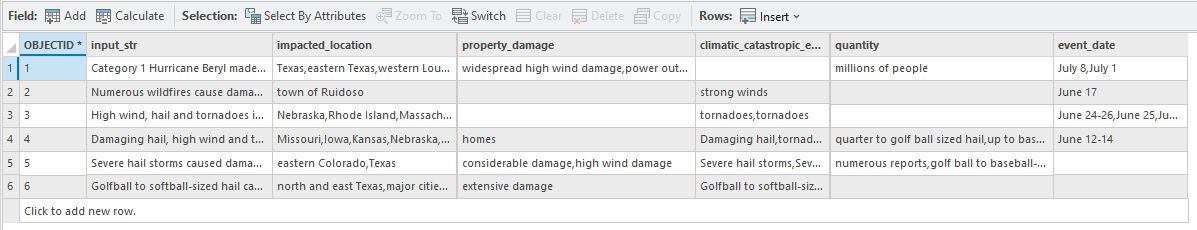

## Conclusion

In this notebook, we have prepared an ESRI Deep Learning Package (.dlpk) file that can leverage a pre-trained model to perform inference in a zero-shot setting.